<a href="https://colab.research.google.com/github/ReidelVichot/DEFreightProfiles/blob/main/Roads_Tracks_infograph%207-28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [77]:
!pip install contextily
import contextily as cx

In [78]:
dir = "/content/drive/MyDrive/FreightProfiles/"

# Import CCD from google drive Source: Census
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(dir + ccd_name)
ccd = ccd.to_crs("EPSG:2235")
# Import tracks from google drive
# Source: Fist Maps
# https://de-firstmap-delaware.hub.arcgis.com/datasets/railroad-rail-lines/explore?location=39.655622%2C-75.765561%2C13.56
rail_name = "Delaware_Multimodal_2.0_tracks/Delaware_Multimodal_2.0.shp"
rail = gpd.read_file(dir + rail_name)
rail = rail.to_crs("EPSG:2235")
cols = ['NAME','geometry']
ccd = ccd[cols]
cols = ['TRACK_TYPE', 'STATUS', 'LINE_ID', 'OWNER', 'geometry']
rail = rail[cols]

taz_name = "/content/drive/MyDrive/temp_dstep23/TAZ_analysis/DE_TAZ_2021_TRKGEN_region.shp"
taz = gpd.read_file(taz_name)
taz = taz.to_crs("EPSG:2235")

taz["FIS"] = taz['NATRES_20'] + taz['CONS_20'] + taz['MANU_20'] + taz['TRN_UTL_20'] + taz['WHL_RET_20'] + taz['FOOD_SVC_2']
taz["SIS"] = taz['OT_SVCS_20'] + taz['ED_HEALTH_'] + taz['FINANCE_20'] + taz['PRO_BUS_20'] + taz['LE_HOSP_20'] + taz['INFO_20']
taz["FIS_per"] = taz["FIS"]/taz['TOT_20']*100
taz_grpd = taz.groupby("CCD").sum(numeric_only = True)
taz_grpd["FIS_per"] = taz_grpd["FIS"]/taz_grpd["TOT_20"]*100
taz_grpd["FIS_capita"] = taz_grpd["FIS"]/taz_grpd["POP_20"]
taz_grpd.reset_index(inplace=True)
taz_grpd.at[ 9, "CCD"] = "Lower Christiana"
taz_grpd.at[25, "CCD"] = "Upper Christiana"
taz_grpd.at[12, "CCD"] = "Middletown-Odessa"
taz_grpd.at[20, "CCD"] = "Pike Creek-Central Kirkwood"
ccd = ccd.merge(taz_grpd, left_on="NAME", right_on="CCD")

CFC = gpd.read_file(dir + "Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0 (1)/Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0.shp")
CFC = CFC.to_crs("EPSG:2235")

#Freight Movement Bottlenecks
FMB = gpd.read_file(dir + "FreightMovementBottlenecks/Delaware_Multimodal_2.0.shp")
FMB = FMB.to_crs("EPSG:2235")

CoastalCorridor = gpd.read_file(dir + "CoastalCorridor/Delaware_Multimodal_2.0.shp")
CoastalCorridor = CoastalCorridor.to_crs("EPSG:2235")

MetroCorridor = gpd.read_file(dir + "MetroCorridor/Delaware_Multimodal_2.0.shp")
MetroCorridor = MetroCorridor.to_crs("EPSG:2235")

LewesCorridor = gpd.read_file(dir + "LewesCorridor/Delaware_Multimodal_2.0.shp")
LewesCorridor = LewesCorridor.to_crs("EPSG:2235")

BayCorridor = gpd.read_file(dir + "BayCorridor/Delaware_Multimodal_2.0.shp")
BayCorridor = BayCorridor.to_crs("EPSG:2235")

PiedmontCorridor = gpd.read_file(dir + "PiedmontCorridor/Delaware_Multimodal_2.0.shp")
PiedmontCorridor = PiedmontCorridor.to_crs("EPSG:2235")

land = gpd.read_file("/content/drive/MyDrive/FreightProfiles/2022_Land_Use_Land_Cover (1)/2022_Land_Use_Land_Cover.shp")
land = land.to_crs("EPSG:2235")
cols = ["LULC_CATEG", "geometry"]
land = land[cols]
land = land[land.LULC_CATEG == "Cropland"]
land_ccd = gpd.overlay(land, ccd, how="intersection")[["NAME", "LULC_CATEG", "geometry"]]
land_ccd["AgLand_acres"] = land_ccd.area*2.29568e-5
ag_land = land_ccd.groupby("NAME").sum(numeric_only=True).reset_index()

ccd = ccd.merge(ag_land, on="NAME", how="left")

In [79]:
truck_traffic = pd.read_csv(dir + "StreetLight/1669875_All_CCDsAvailable_trucks_2020/1669875_All_CCDsAvailable_trucks_2020/1669875_All_CCDsAvailable_trucks_2020_odg_comm.csv")
cols = ['Vehicle Weight', 'Origin Zone ID', 'Origin Zone Name',
        'Origin Zone Source', 'Destination Zone ID', 'Destination Zone Name',
        'Destination Zone Source', 'Day Type', 'Day Part',
        'Average Daily O-D Traffic (StL Index)',
        'Average Daily Origin Zone Traffic (StL Index)',
       'Average Daily Destination Zone Traffic (StL Index)',
       'Avg Travel Time (sec)']
truck_traffic = truck_traffic[cols]
truck_traffic2 = truck_traffic[truck_traffic["Day Type"]=="0: All Days (M-Su)"][truck_traffic['Day Part']=="00: All Day (12am-12am)"].groupby("Destination Zone Name").sum(numeric_only=True).reset_index()
truck_traffic_ccd = truck_traffic2[truck_traffic2["Destination Zone Name"].isin(ccd["NAME"].values)][['Destination Zone Name', 'Average Daily O-D Traffic (StL Index)']]
ccd  = ccd.merge(truck_traffic_ccd, left_on="CCD", right_on="Destination Zone Name", how="left")
ccd["z-score"] = (ccd["Average Daily O-D Traffic (StL Index)"] - ccd["Average Daily O-D Traffic (StL Index)"].mean())/ccd["Average Daily O-D Traffic (StL Index)"].std()

<ipython-input-79-00d5e9eaa0f9>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  truck_traffic2 = truck_traffic[truck_traffic["Day Type"]=="0: All Days (M-Su)"][truck_traffic['Day Part']=="00: All Day (12am-12am)"].groupby("Destination Zone Name").sum(numeric_only=True).reset_index()


In [80]:
truck_parking_name =  dir + "DE_Undesig_Clusters/DE_Undesig_Clusters/Delaware_Undesig_Clusters.shp"
truck_parking =  gpd.read_file(truck_parking_name)
truck_parking = truck_parking.to_crs("EPSG:2235")
truck_parking["Parking"] = "Truck Parking"

In [81]:
# Original
#CCD = "Dover"
#resol = 85000
#x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
#x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
#y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol
#y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol

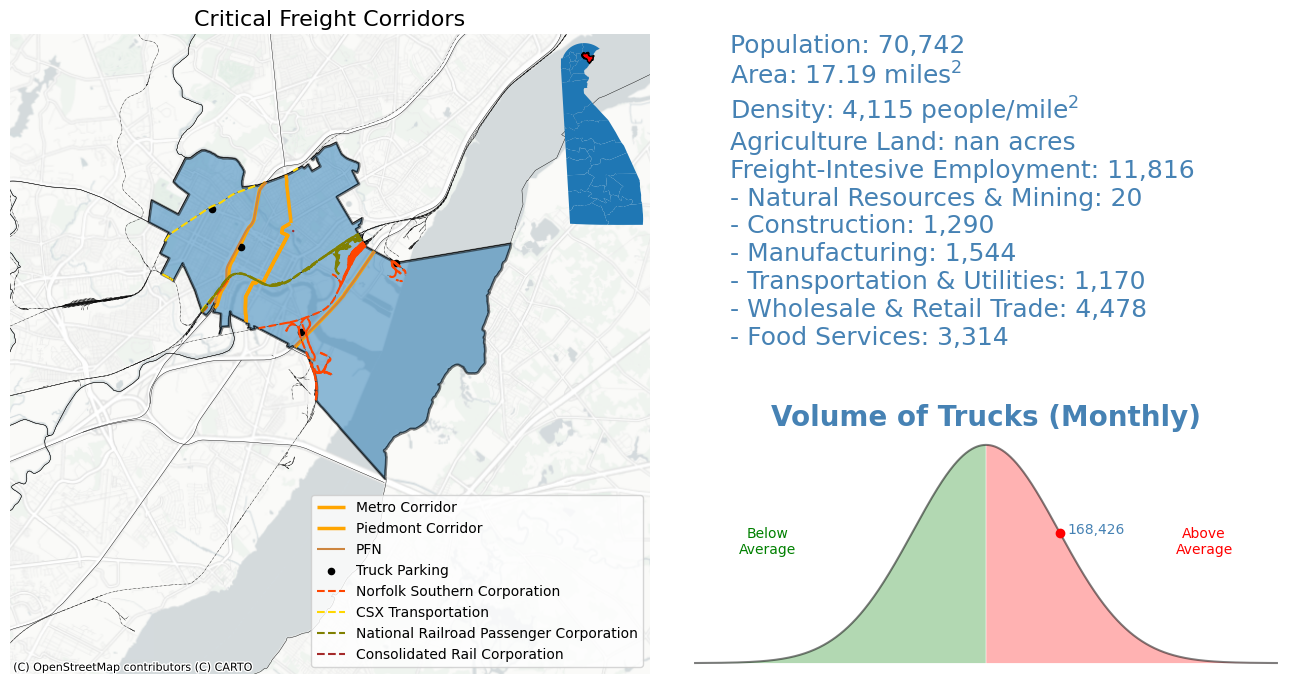

In [91]:
import warnings
# Ignore specific warning
warnings.filterwarnings("ignore", message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.")
# Ignore specific warning
warnings.filterwarnings("ignore", message="Only specify one of 'column' or 'color'. Using 'color'.")


CCD = "Wilmington"
resol = 30000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol  - 6000
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol - 6000



font = {'color':  'black',
        'weight': 'normal',
        'size': 16}
# [left, bottom, width, height]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0.05, 0.05, 0.4, 0.8])

plt.title("Critical Freight Corridors", fontdict=font)
ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)
CFC.plot(color="k", linestyle="-", lw = 0.3, ax=ax)
metro_intercept = gpd.overlay(MetroCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
metro_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Metro Corridor', color="orange",
                             zorder=1);
piedmont_intercept = gpd.overlay(PiedmontCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
piedmont_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Piedmont Corridor', color="orange",
                             zorder=1);
bay_intercept = gpd.overlay(BayCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
bay_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Bay Corridor', color="orange",
                             zorder=1);
lewes_intercept = gpd.overlay(LewesCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
lewes_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Lewes Corridor', color="orange",
                             zorder=1);
coastal_intercept = gpd.overlay(CoastalCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
coastal_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Coastal Corridor', color="wheat",
                             zorder=1);
intersept = gpd.overlay(CFC, ccd[ccd["NAME"]==CCD], how="intersection")

intersept[intersept["FREIGHT_NE"]=='CUFC'].plot(linestyle="-", ax=ax,
                             label = 'CUFC', color="steelblue");
intersept[intersept["FREIGHT_NE"]== 'CRFC'].plot(linestyle="-", ax=ax,
                             label = 'CRFC', color="darkgreen");
intersept[intersept["FREIGHT_NE"]== 'PFN'].plot(linestyle="-", ax=ax,
                             label = 'PFN', color="peru");
bottleneck_intersect = gpd.overlay(FMB, ccd[ccd["NAME"]==CCD], how="intersection")
bottleneck_intersect.plot("ROADNAME", linestyle="-", ax=ax,
                             label = "Bottleneck", color="red");
rail.plot(color="k", linestyle="-.", lw = 0.3, ax=ax)


truck_parking_intercept = gpd.overlay(truck_parking, ccd[ccd["NAME"]==CCD], how="intersection")
truck_parking_intercept.geometry.centroid.plot(color="k", markersize=20, ax=ax, label="Truck Parking", zorder=1)
ax.legend(loc='lower right')


palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

for i in range(len(rail["OWNER"].unique())):
  intersect_rail = gpd.overlay(rail[rail.OWNER==rail["OWNER"].unique()[i]], ccd[ccd["NAME"]==CCD], how="intersection");
  intersect_rail.plot("OWNER", linestyle="--", ax=ax, label = rail["OWNER"].unique()[i], color = palette[i]);

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

ax2 = fig.add_axes([0.37, 0.60, 0.1, 0.25])
ccd.plot(ax=ax2)
ccd[ccd['NAME'] == CCD].plot(ax=ax2, color="r", edgecolor="k", lw = 1)
ax2.set_axis_off()

ax3 = fig.add_axes([0.460, 0.40, 0.4, 0.45])
ax3.set_axis_off()

ax4 = fig.add_axes([0.460, 0.05, 0.4, 0.3])
# prompt: plot a bell curve
# Define the x-axis values
x = np.linspace(-4, 4, 1000)
# Define the y-axis values using the normal distribution function
y = np.exp(-x**2 / 2) / (np.sqrt(2 * np.pi))
# The z-score
z = ccd[ccd["NAME"]==CCD]["z-score"].values[0]

# Create the plot
ax4.plot(x, y, alpha=0.5, color="k")

# Add labels and title
ax4.set_axis_off()
plt.title("Volume of Trucks (Monthly)", color="steelblue", weight="bold", fontsize=20)

# Add a dot on the bell curve at x = 1
ax4.plot(z, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), marker="o", color="red")
if z > 0:
  ax4.text(z+0.1, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["Average Daily O-D Traffic (StL Index)"].values[0]), color="steelblue", ha="left")
else:
  ax4.text(z-0.1, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["Average Daily O-D Traffic (StL Index)"].values[0]), color="steelblue", ha="right")
# Fill the area under the curve with green color
ax4.fill_between(x, y, 0, where=x <= 0, facecolor="green", alpha=0.3)
ax4.fill_between(x, y, 0, where=x > 0, facecolor="red", alpha=0.3)
ax4.text(-3,0.2, "Below\nAverage", color="green", alpha=1, fontsize=10, ha="center")
ax4.text( 3,0.2, "Above\nAverage", color="red", alpha=1, fontsize=10, ha="center")

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
ax.legend(loc='lower right')

#header = fig.text(0.5, 0.90, "Freight Profile: " + CCD, fontsize=20, color="k", weight="bold", ha="center")
content =  fig.text(0.5, 0.85,  "Population: " +  "{:,}".format(ccd[ccd["NAME"]==CCD]["POP_20"].values[0]) + "\n" +
                                "Area: " + "{:,.2f}".format(ccd[ccd["NAME"]==CCD].area.values[0]*3.58701e-8) + " miles$^2$\n" +
                                "Density: " + "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["POP_20"].values[0] / ccd[ccd["NAME"]==CCD].area.values[0] / 3.58701e-8) + " people/mile$^2$\n" +
                                "Agriculture Land: " + "{:,.0f} acres".format(ccd[ccd["NAME"]==CCD]['AgLand_acres'].values[0]) + "\n" +
                                "Freight-Intesive Employment: " + "{:,}".format(ccd[ccd["NAME"]==CCD]["FIS"].values[0]) + "\n" +
                                "- Natural Resources & Mining: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['NATRES_20'].values[0]) + "\n" +
                                "- Construction: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['CONS_20'].values[0]) + "\n" +
                                "- Manufacturing: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['MANU_20'].values[0]) + "\n" +
                                "- Transportation & Utilities: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['TRN_UTL_20'].values[0]) + "\n" +
                                "- Wholesale & Retail Trade: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['WHL_RET_20'].values[0]) + "\n"
                                "- Food Services: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['FOOD_SVC_2'].values[0]) + "\n"
                                , color="steelblue", weight="normal", va="top", fontsize=18)
fig.show()

In [83]:
stop

NameError: name 'stop' is not defined

In [ ]:
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd2 =  gpd.read_file(dir + ccd_name)[["NAME", "geometry"]]
ccd2 = ccd2.to_crs("EPSG:2235")
truck_parking_temp = gpd.overlay(truck_parking, ccd2, how="intersection")
temp1 = truck_parking_temp.groupby("NAME").sum(numeric_only=True).reset_index()
temp2 = truck_parking_temp.groupby("NAME").count().reset_index()[["NAME", "Parking"]]
parking = temp1.merge(temp2, on="NAME")

ccd_updated = ccd.merge(parking, on="NAME", how="left")

In [ ]:
CFC_ccd = gpd.overlay(CFC, ccd, how="intersection")
CFC_ccd["length_CFC"] = CFC_ccd.length
CFC_ccd = CFC_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_CFC"]]

PiedmontCorridor_ccd = gpd.overlay(PiedmontCorridor, ccd, how="intersection", keep_geom_type=True)
PiedmontCorridor_ccd["length_Piedmont"] = PiedmontCorridor_ccd.length
PiedmontCorridor_ccd = PiedmontCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Piedmont"]]

CoastalCorridor_ccd = gpd.overlay(CoastalCorridor, ccd, how="intersection", keep_geom_type=True)
CoastalCorridor_ccd["length_Coastal"] = CoastalCorridor_ccd.length
CoastalCorridor_ccd = CoastalCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Coastal"]]

MetroCorridor_ccd = gpd.overlay(MetroCorridor, ccd, how="intersection", keep_geom_type=True)
MetroCorridor_ccd["length_Metro"] = MetroCorridor_ccd.length
MetroCorridor_ccd = MetroCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Metro"]]

#--- Empty
LewesCorridor_ccd = gpd.overlay(LewesCorridor, ccd, how="intersection", keep_geom_type=True)
LewesCorridor_ccd["length_Lewes"] = LewesCorridor_ccd.length
LewesCorridor_ccd = LewesCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Lewes"]]

BayCorridor_ccd = gpd.overlay(BayCorridor, ccd, how="intersection", keep_geom_type=True)
BayCorridor_ccd["length_Bay"] = BayCorridor_ccd.length
BayCorridor_ccd = BayCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Bay"]]

ccd = ccd.merge(CFC_ccd, on="NAME", how="left").fillna(0)
ccd = ccd.merge(PiedmontCorridor_ccd, on="NAME", how="left").fillna(0)
ccd = ccd.merge(CoastalCorridor_ccd, on="NAME", how="left").fillna(0)
ccd = ccd.merge(MetroCorridor_ccd, on="NAME", how="left").fillna(0)
# Empty
#ccd = ccd.merge(LewesCorridor_ccd, left_on="CCD", right_on="NAME", how="left")
ccd = ccd.merge(BayCorridor_ccd, on="NAME", how="left").fillna(0)

# Before remove Lewes Corridor
#ccd["freight_length"] = ccd["length_CFC"] + ccd["length_Piedmont"] + ccd["length_Coastal"] + ccd["length_Metro"] + ccd["length_Lewes"] + ccd["length_Bay"]
ccd["freight_length"] = ccd["length_CFC"] + ccd["length_Piedmont"] + ccd["length_Coastal"] + ccd["length_Metro"] + ccd["length_Bay"]

ccd = ccd.drop(columns=["NAME"])

rail_ccd = gpd.overlay(rail, ccd, how="intersection", keep_geom_type=True)
rail_ccd["rail_length"] = rail_ccd.length
rail_ccd = rail_ccd.groupby("CCD").sum(numeric_only=True).reset_index()[["CCD","rail_length"]]

ccd = ccd.merge(rail_ccd, on="CCD", how="left").fillna(0)

# Adding parking values
dir = "/content/drive/MyDrive/FreightProfiles/"
truck_parking_name =  dir + "DE_Undesig_Clusters/DE_Undesig_Clusters/Delaware_Undesig_Clusters.shp"
truck_parking =  gpd.read_file(truck_parking_name)
truck_parking = truck_parking.to_crs("EPSG:2235")
#truck_parking["geometry"] = truck_parking.centroid

truck_parking_ccd = gpd.overlay(truck_parking, ccd[["CCD","geometry"]], how="intersection")

count_parking = truck_parking_ccd.groupby("CCD").count()[["geometry"]].reset_index()
count_parking.columns = ["CCD","count_parking"]
count_spots = truck_parking_ccd.groupby("CCD").sum(numeric_only=True).reset_index()
count_spots.columns = ["CCD","count_spots"]
ccd = ccd.merge(count_parking, on="CCD", how="left").fillna(0)
ccd = ccd.merge(count_spots, on="CCD", how="left").fillna(0)

ccd.rename(columns={"Average Daily O-D Traffic (StL Index)":"StL_Index"}, inplace=True)

In [ ]:
truck_parking_ccd.sort_values("CCD")

In [ ]:
ccd_x =  gpd.read_file(dir + ccd_name)
ccd_x = ccd_x.to_crs("EPSG:2235")
ccd_x = ccd_x[["NAME", "geometry"]]
ccd_x.columns = ["CCD", "geometry"]
cols = ['DESCRIPTIO', 'NAME', 'MILES', 'ROADNUMBER', 'ROADNAME', 'TRUCK_PERC', 'geometry']

FMB_reduced = FMB[cols]
gpd.overlay(FMB_reduced, ccd_x, how="intersection").sort_values("CCD")

In [ ]:
gpd.overlay(FMB_reduced, ccd_x, how="intersection").sort_values("CCD").length * 0.00018939393935722

In [ ]:
# -- import statmodels using the formula api
import statsmodels.formula.api as sm

# -- first build the model
model = sm.ols("StL_Index ~ AgLand_acres + FIS + count_parking + freight_length", data=ccd)

# -- now fit the model to the data
result = model.fit()

# -- summarize the model fit
print(result.summary())

#Land Use

In [ ]:
# use land use file 2022
land_use = gpd.read_file(dir + "2022_Land_Use_Land_Cover (1)/2022_Land_Use_Land_Cover.shp")
land_use = land_use.to_crs("EPSG:2235")

# select columns of interest
cols = ['LULC_CATEG', 'Shape__Are', 'Shape__Len', 'geometry']
land_use = land_use[cols]

In [ ]:
land_use.area / 43560


In [ ]:
land_use

#Axle Data

In [92]:
axle = gpd.read_file(dir + "Data_Axle_2022_DE_point (1)/Data_Axle_2022_DE_point.shp")
axle = axle.to_crs("EPSG:2235")

In [93]:
axle.head()

,first_name,last_name,company,address_li,city,state,zipcode,zip4,area_code,phone_numb,...,sic6_des01,sic_code_2,sic6_des02,sic_code_3,sic6_des03,sic_code_4,sic6_des04,latitude,longitude,geometry
0,SHALEEN R,OZA,None,1600 ROCKLAND RD,WILMINGTON,DE,19803,3607,302,6514200,...,None,None,None,None,None,None,None,39.776825,-75.556768,POINT (616788.161 647176.324)
1,GABRIEL,PELAEZ,None,2000 FOULK RD # F,WILMINGTON,DE,19810,3642,302,6528990,...,None,None,None,None,None,None,None,39.813410,-75.509747,POINT (630018.288 660485.989)
2,UJWALA,DIXIT,HEALTHY MINDS,1309 VEALE RD # 21,EDGEMOOR,DE,19810,4609,302,4770977,...,None,None,None,None,None,None,None,39.800792,-75.503839,POINT (631673.503 655887.931)
3,None,None,MCALLISTER FIRM LLC,800 N KING ST,WILMINGTON,DE,19801,3550,302,5435158,...,None,None,None,None,None,None,None,39.743169,-75.547814,POINT (619286.929 634912.663)
4,DAVID,COMPTON,COMPTON ANESTHESIOLOGY LLC,2710 CENTERVILLE RD # 100,WILMINGTON,DE,19808,1652,302,9990200,...,None,None,None,None,None,None,None,39.754083,-75.623421,POINT (598034.761 638928.377)


In [94]:
axle.columns

Index(['first_name', 'last_name', 'company', 'address_li', 'city', 'state',
       'zipcode', 'zip4', 'area_code', 'phone_numb', 'fax_area_c',
       'fax_phone_', 'profession', 'title_code', 'gender', 'idcode',
       'employee_s', 'employee00', 'modeled_em', 'parent_emp', 'location_e',
       'parent_act', 'sales_volu', 'sales_vo00', 'parent_sal', 'location_s',
       'parent_a00', 'abi', 'parent_num', 'subsidiary', 'address_ty',
       'business_s', 'call_statu', 'company_ho', 'industry_s', 'name_stand',
       'office_siz', 'population', 'site_numbe', 'square_foo', 'yellow_pag',
       'ad_size_co', 'book_numbe', 'archive_ve', 'archive_00', 'new_add_da',
       'teleresear', 'year_1st_a', 'year_estab', 'cbsa_code', 'cbsa_level',
       'census_blo', 'census_tra', 'county_cod', 'csa_code', 'fips_code',
       'match_code', 'location_n', 'landmark_a', 'landmark_c', 'landmark_s',
       'landmark_z', 'landmark00', 'mailing_ad', 'mailing_ci', 'mailing_st',
       'mailing_zi', 'mailing

In [107]:
cols = ['company', 'address_li', 'city', 'state',
       'zipcode', 'employee_s', 'employee00',
       'parent_act', 'sales_volu', 'sales_vo00', 'parent_sal', 'location_s',
       'parent_a00', 'abi', 'parent_num', 'subsidiary',
       'business_s', 'call_statu', 'company_ho', 'industry_s', 'name_stand',
       'office_siz', 'population', 'site_numbe', 'square_foo',
       'ad_size_co',  'archive_ve', 'archive_00', 'new_add_da',
       'teleresear', 'year_1st_a', 'year_estab', 'cbsa_code', 'cbsa_level',
       'census_blo', 'census_tra', 'county_cod', 'csa_code', 'fips_code',
       'match_code', 'location_n', 'landmark_a', 'landmark_c', 'landmark_s',
       'landmark_z', 'landmark00',
       'naics_code', 'primary_na', 'naics8_des', 'geometry']
axle = axle[cols]

In [108]:
axle.head()

,company,address_li,city,state,zipcode,employee_s,employee00,parent_act,sales_volu,sales_vo00,...,location_n,landmark_a,landmark_c,landmark_s,landmark_z,landmark00,naics_code,primary_na,naics8_des,geometry
0,None,1600 ROCKLAND RD,WILMINGTON,DE,19803,0,0,0,0,0,...,"OZA, SHALEEN R MD",NEMOURS/AI DUPONT HOSP-CHILDRN,WILMINGTON,DE,19803,None,0,62111107,OFFICES OF PHYSICIANS (EXC MENTAL HEALTH SPECS),POINT (616788.161 647176.324)
1,None,2000 FOULK RD # F,WILMINGTON,DE,19810,0,0,0,0,0,...,"PELAEZ, GABRIEL",FOULK ROAD OFFICE PARK PLZ,WILMINGTON,DE,19810,None,0,62139932,OFFICES OF ALL OTHER MISC HEALTH PRACTITIONERS,POINT (630018.288 660485.989)
2,HEALTHY MINDS,1309 VEALE RD # 21,EDGEMOOR,DE,19810,3,0,0,605,0,...,HEALTHY MINDS,None,None,None,0,None,0,62111107,OFFICES OF PHYSICIANS (EXC MENTAL HEALTH SPECS),POINT (631673.503 655887.931)
3,MCALLISTER FIRM LLC,800 N KING ST,WILMINGTON,DE,19801,0,0,0,0,0,...,MCALLISTER FIRM LLC,None,None,None,0,None,0,54111002,OFFICES OF LAWYERS,POINT (619286.929 634912.663)
4,COMPTON ANESTHESIOLOGY LLC,2710 CENTERVILLE RD # 100,WILMINGTON,DE,19808,0,0,0,0,0,...,COMPTON ANESTHESIOLOGY LLC,None,None,None,0,None,0,62111107,OFFICES OF PHYSICIANS (EXC MENTAL HEALTH SPECS),POINT (598034.761 638928.377)
